<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [3]:
import numpy as np
import random
import io
import pickle
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, utils
import keras.backend as K

from keras.utils.np_utils import to_categorical
from keras.utils import pad_sequences
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout

In [136]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [226]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
- Del dataset unicamente utilizo las columnas "Review Text" y "Rating".
- Tranformo el rating de 1-5 a una escala numérica de 0 a 4.



In [227]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [228]:
import re

# Filtro caracteres especiales de los reviews usando regex
def remove_special_characters(text):
    return re.sub(r'[^\w\s]', '', text)

df_reviews['Review Text'] = df_reviews['Review Text'].apply(lambda x: remove_special_characters(x))
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful silky and sexy and comfo...,3
1,Love this dress its sooo pretty i happened t...,4
2,I had such high hopes for this dress and reall...,2
3,I love love love this jumpsuit its fun flirty ...,4
4,This shirt is very flattering to all due to th...,4


- Elimino las stop words utilizando NLTK

In [229]:
stop_words = set(stopwords.words('english'))

# Funcion para filtrar las stop words de los reviews del dataframe
def filter_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text
  
df_reviews['Review Text'] = df_reviews['Review Text'].apply(filter_stopwords)
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful silky sexy comfortable,3
1,Love dress sooo pretty happened find store im ...,4
2,high hopes dress really wanted work initially ...,2
3,love love love jumpsuit fun flirty fabulous ev...,4
4,shirt flattering due adjustable front tie perf...,4


Se puede ver que se eliminan las palabras comúnes, como "and", "this", "I", "its", etc.

- Observo la distribución de las diferentes clases. 

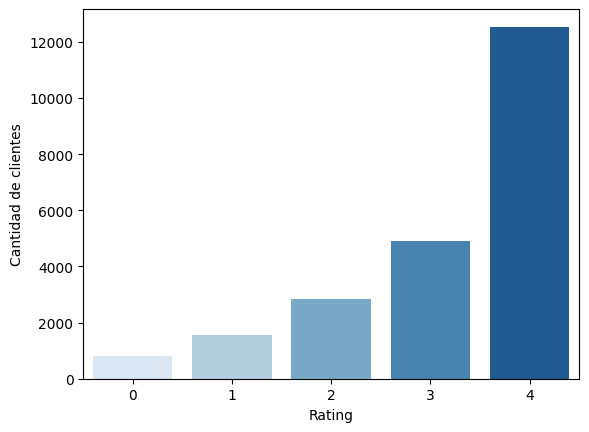

Rating 1: 821 clientes
Rating 2: 1549 clientes
Rating 3: 2823 clientes
Rating 4: 4908 clientes
Rating 5: 12540 clientes


In [230]:
sns.countplot(data=df_reviews, x='Rating', palette = 'Blues')
plt.xlabel('Rating');plt.ylabel('Cantidad de clientes')
plt.show()

unique_class, counts = np.unique(df_reviews['Rating'], return_counts=True)
for unique_class, counts in zip(unique_class, counts):
  print(f'Rating {unique_class+1}: {counts} clientes')

- Se exhibe que están altamente desbalanceadas, lo cual afectará de forma negativa el desempeño del modelo. Por este motivo, se decide convertir el trabajo en una clasificación entre 3 clases:
  - Rating Malo (0): rating 1 o 2 (0 o 1 en el `df_reviews`).
  - Rating Bueno (1): rating 3 o 4 (2 o 3 en el `df_reviews`).
  - Rating Muy bueno (2): rating 5 (4 en el `df_reviews`).

In [231]:
df_reviews['Grouped_Rating'] = df_reviews['Rating'].apply(lambda x: 0 if x in [0, 1] else 1 if x in [2, 3] else 2)
df_reviews.head()

,Review Text,Rating,Grouped_Rating
0,Absolutely wonderful silky sexy comfortable,3,1
1,Love dress sooo pretty happened find store im ...,4,2
2,high hopes dress really wanted work initially ...,2,1
3,love love love jumpsuit fun flirty fabulous ev...,4,2
4,shirt flattering due adjustable front tie perf...,4,2


- Observo la distribución de las nuevas clases agrupadas. 

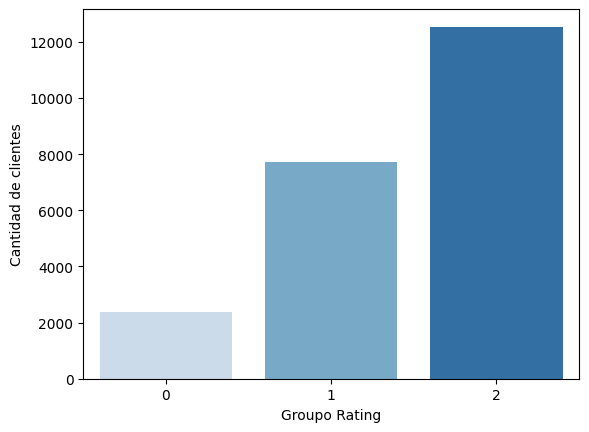

Rating 1: 2370 clientes
Rating 2: 7731 clientes
Rating 3: 12540 clientes


In [232]:
sns.countplot(data=df_reviews, x='Grouped_Rating', palette = 'Blues')
plt.xlabel('Groupo Rating');plt.ylabel('Cantidad de clientes')
plt.show()

unique_class, counts = np.unique(df_reviews['Grouped_Rating'], return_counts=True)
for unique_class, counts in zip(unique_class, counts):
  print(f'Rating {unique_class+1}: {counts} clientes')

Puesto que existe una mayor proporción de la clase 2, luego de separar el dataset en entrenamiento y testeo, se va a realizar un oversampling.

- Almaceno los `Review Text` como un vector de NumPy

In [233]:
reviews = df_reviews['Review Text'].to_numpy()
# Imprimo los primeros 5 reviews
for i in range(0,5):
  print(reviews[i])

# Imprimo cantidad de reviews
print(f'\nEl dataset tiene {len(reviews)} reviews')

Absolutely wonderful silky sexy comfortable
Love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite 58 love length hits little knee would definitely true midi someone truly petite
high hopes dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layers imo major design flaw net layer sewn directly zipper c
love love love jumpsuit fun flirty fabulous every time wear get nothing great compliments
shirt flattering due adjustable front tie perfect length wear leggings sleeveless pairs well cardigan love shirt

El dataset tiene 22641 reviews


- Concateno todas las reviews para armar el corpus

In [234]:
corpus = ' '.join(reviews)

# Imprimo longitud del corpus
print(f'\nEl corpus tiene un largo de {len(corpus)}')


El corpus tiene un largo de 4268823


- Utilizo `text_to_word_sequence` para separar las palabras en tokens

In [235]:
tokens = text_to_word_sequence(corpus)
# Visualizo los primeros 20 tokens
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happened',
 'find',
 'store',
 'im',
 'glad',
 'bc',
 'never',
 'would',
 'ordered',
 'online',
 'bc']

In [236]:
# Imprimo cantidad de tokens totales
print(f'\nEl corpus tiene {len(tokens)} tokens')


El corpus tiene 668234 tokens


- Tokenizo las palabras con `Tokenizer` de Keras

In [237]:
from keras.preprocessing.text import Tokenizer

# Defino la cantidad máxima de palabras a utilizar en el Tokenizer con num_words
vocab_size = 8000
tok = Tokenizer(num_words=vocab_size) 
tok.fit_on_texts(tokens)

- Obtengo un diccionario de palabra a índices

In [238]:
word2index = tok.word_index

# Imprimo la cantidad total del vocabulario
print(f'\nEl corpus tiene un vocabulario de largo {len(word2index)}.')


El corpus tiene un vocabulario de largo 19230.


- Conversión de tokens a números

In [239]:
sequences = tok.texts_to_sequences(reviews)
# Imprimo las primeras review y su formato de secuencia
print(f'Review: {reviews[0]} \nSecuencia: {sequences[0]}')

Review: Absolutely wonderful silky sexy comfortable 
Secuencia: [173, 429, 800, 553, 24]


In [240]:
# Determino cual es la oración más larga
max_sentence = max(len(s) for s in sequences)
print(f'La oración más larga tiene un largo de {max_sentence}')

La oración más larga tiene un largo de 61


- Realizo padding para que las sequencias tengan el mismo tamaño

In [241]:
maxlen = max_sentence
X = pad_sequences(sequences, padding='pre', maxlen=max_sentence)

# Imprimo el padding de la primera secuencia
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 173, 429, 800, 553,  24], dtype=int32)

In [242]:
# Imprimo las dimensiones de la variable input
print(f'Las dimensiones de la matriz de entrada son: {X.shape}')

Las dimensiones de la matriz de entrada son: (22641, 61)


In [244]:
# Guardo la variable de salida (rating agrupado) en un array de NumPy
y_numpy = df_reviews["Grouped_Rating"].to_numpy()

- Transformo la variable de salida (rating) con One Hot Encoding

In [245]:
y_cat = to_categorical(y_numpy)

print(f'Las dimensiones de la matriz de salida son: {y_cat.shape}')

Las dimensiones de la matriz de salida son: (22641, 3)


In [246]:
# Imprimo la salida de la primera secuencia que debe tener un rating de 4
y_cat[0]

array([0., 1., 0.], dtype=float32)

- Divido los datos en train y test

In [247]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

print(f'Tamaños train:')
print(f'X: {X_train.shape}, y: {y_train.shape}')
print(f'Tamaños test:')
print(f'X: {X_test.shape}, y: {y_test.shape}')

Tamaños train:
X: (18112, 61), y: (18112, 3)
Tamaños test:
X: (4529, 61), y: (4529, 3)


- Oversampling de las variables minoritarias para balancear el dataset de entrenamiento. 

In [248]:
oversample = RandomOverSampler(random_state=42)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [249]:
num_classes = y_over.shape[1]
class_counts = np.sum(y_over, axis=0)

for class_idx in range(num_classes):
    print(f'Rating {class_idx+1}: {class_counts[class_idx]} clientes')

Rating 1: 10032 clientes
Rating 2: 10032 clientes
Rating 3: 10032 clientes


In [250]:
X_train_over, y_train_over = X_over, y_over
print(f'Tamaños train antes del oversampling:')
print(f'X: {X_train.shape}, y: {y_train.shape}')
print(f'Tamaños train despúes del oversampling:')
print(f'X: {X_train_over.shape}, y: {y_train_over.shape}')

Tamaños train antes del oversampling:
X: (18112, 61), y: (18112, 3)
Tamaños train despúes del oversampling:
X: (30096, 61), y: (30096, 3)


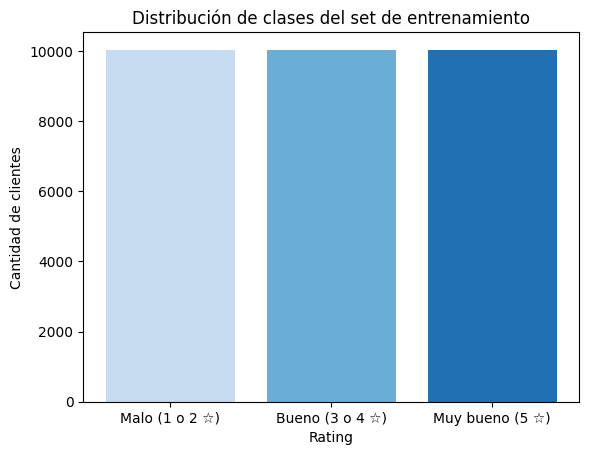

In [251]:
class_labels = ['Malo (1 o 2 ☆)', 'Bueno (3 o 4 ☆)', 'Muy bueno (5 ☆)']
plt.bar(class_labels, class_counts, color = sns.color_palette("Blues", num_classes))
plt.xlabel('Rating'); plt.ylabel('Cantidad de clientes'); plt.title('Distribución de clases del set de entrenamiento')
plt.show()

In [252]:
# Determinar la dimensiones de entrada y salida 
in_shape = X_train_over.shape[1]
out_shape = y_train_over.shape[1]

print(f'Dimensiones de entrada: {in_shape} \nDimensiones de salida: {out_shape}')

Dimensiones de entrada: 61 
Dimensiones de salida: 3


#### 1.1 Word Clouds

##### 1.1.1 Todos los ratings

In [253]:
# Palabras rating malo
class_0 = df_reviews[df_reviews["Grouped_Rating"] == 0]['Review Text']
class_0 = " ".join(class_0).split()

# Palabras rating bueno
class_1 = df_reviews[df_reviews["Grouped_Rating"] == 1]['Review Text']
class_1 = " ".join(class_1).split()

# Palabras rating muy bueno
class_2 = df_reviews[df_reviews["Grouped_Rating"] == 2]['Review Text']
class_2 = " ".join(class_2).split()

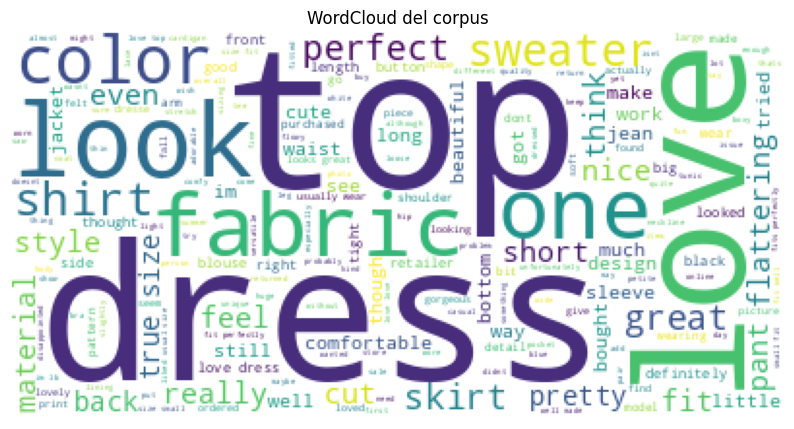

In [255]:
from wordcloud import WordCloud 

wordcloud_all = WordCloud(background_color="white", max_words =250).generate(corpus)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_all); plt.axis("off"); plt.title('WordCloud del corpus');plt.show()

##### 1.1.2 Rating Malo (1 o 2 ☆)

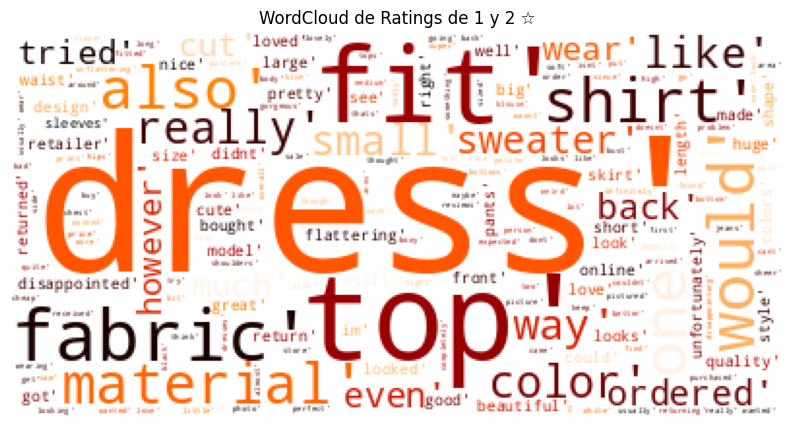

In [256]:
wordcloud_0 = WordCloud(background_color="white", max_words =250, colormap='gist_heat').generate(str(class_0))

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_0); plt.axis("off"); plt.title('WordCloud de Ratings de 1 y 2 ☆'); plt.show()

##### 1.1.3 Rating Bueno (3 o 4 ☆)

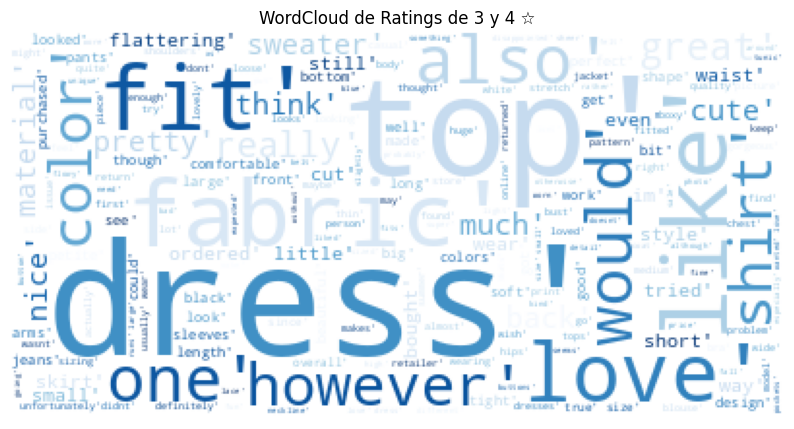

In [257]:
wordcloud_1 = WordCloud(background_color="white", max_words =250, colormap='Blues').generate(str(class_1))

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_1); plt.axis("off"); plt.title('WordCloud de Ratings de 3 y 4 ☆');plt.show()

##### 1.1.4 Rating Muy Bueno (5 ☆)

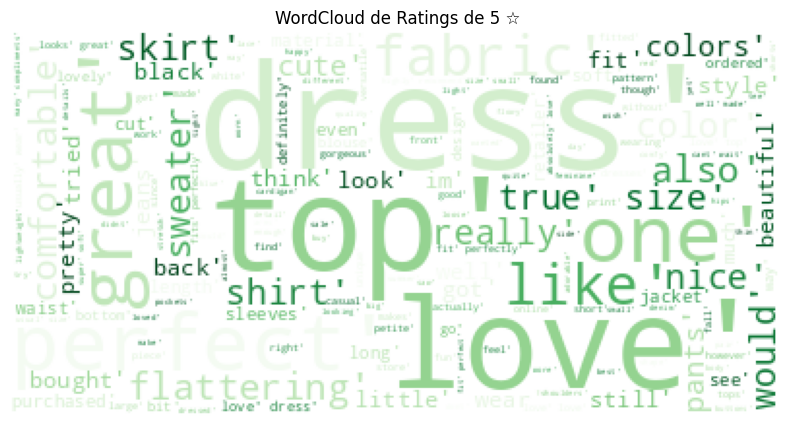

In [258]:
wordcloud_2 = WordCloud(background_color="white", max_words =250, colormap='Greens').generate(str(class_2))

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_2); plt.axis("off"); plt.title('WordCloud de Ratings de 5 ☆'); plt.show()

Se puede observar que el word cloud de la clase 3 es el más similar al corpus total, puesto que es la clase mayoritaria. Por otro lado, los word clouds de las clases 0 y 1 son similares, teniendo palabras importantes en común como fit y fabric. Sin embargo, hay palabras muy presentes en todos los casos como "dress" y "top"

### 2 - Entrenamiento de modelo con Embeddings + LSTM

- Defino función para evaluar el F1 score. Tomada de: [link](https://datascience.stackexchange.com/questions/105101/which-keras-metric-for-multiclass-classification)

In [259]:
# Defino función para evaluar empleando F1 score
def f1_score(y_true, y_pred):    

    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall   
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

- Defino arquitectura del modelo de Keras

In [265]:
# Defino mi modelo
# Agrego regularizacion l2 y dropout layers para reducir el overfitting
model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=50, input_length=in_shape))

model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer='l2')))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(units=64, kernel_regularizer='l2')))
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu", kernel_regularizer='l2'))
model.add(Dropout(0.5))

model.add(Dense(out_shape, activation="softmax"))

# Puesto que el dataset fue balanceado utilizando oversampling, se puede emplear la métrica de accuracy
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[f1_score])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 61, 50)            400050    
                                                                 
 bidirectional_14 (Bidirecti  (None, 61, 256)          183296    
 onal)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 61, 256)           0         
                                                                 
 bidirectional_15 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)              

- Entreno la red durante 100 epochs e implemento un callback para detener el entrenamiento cuando el loss deja de mejorar.

In [267]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [268]:
hist = model.fit(X_train_over, y_train_over, epochs=100, validation_split=0.2, callbacks=[callback], batch_size=2048)

Epoch 1/100
12/12 [==============================] - 14s 437ms/step - loss: 7.8082 - f1_score: 0.0083 - val_loss: 6.7903 - val_f1_score: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 3s 219ms/step - loss: 5.8183 - f1_score: 0.0340 - val_loss: 5.0798 - val_f1_score: 0.0000e+00
Epoch 3/100
12/12 [==============================] - 3s 233ms/step - loss: 4.2949 - f1_score: 0.2072 - val_loss: 4.1424 - val_f1_score: 0.0000e+00
Epoch 4/100
12/12 [==============================] - 3s 212ms/step - loss: 3.0916 - f1_score: 0.5856 - val_loss: 2.8796 - val_f1_score: 0.3273
Epoch 5/100
12/12 [==============================] - 3s 278ms/step - loss: 2.2518 - f1_score: 0.6987 - val_loss: 2.2190 - val_f1_score: 0.3404
Epoch 6/100
12/12 [==============================] - 2s 194ms/step - loss: 1.6837 - f1_score: 0.7281 - val_loss: 1.7467 - val_f1_score: 0.5250
Epoch 7/100
12/12 [==============================] - 3s 208ms/step - loss: 1.2950 - f1_score: 0.7612 - val_loss: 1.3416 - val_f1_

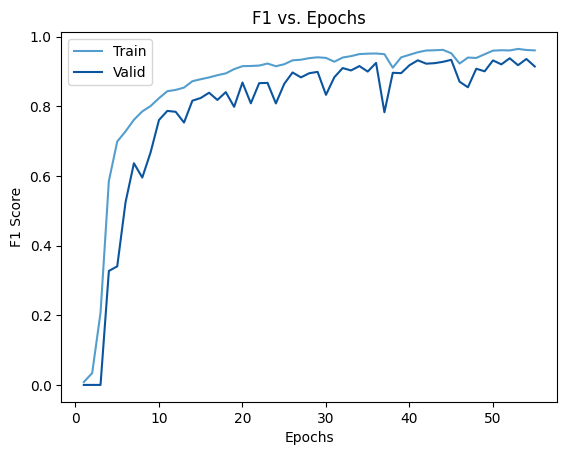

In [269]:
# Grafico F1 Score
blues_palette = sns.color_palette("Blues")
epoch_count = range(1, len(hist.history["f1_score"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["f1_score"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist.history["val_f1_score"], label="Valid", color=blues_palette[5])
plt.ylabel('F1 Score'); plt.xlabel('Epochs'); plt.title('F1 vs. Epochs'); plt.show()

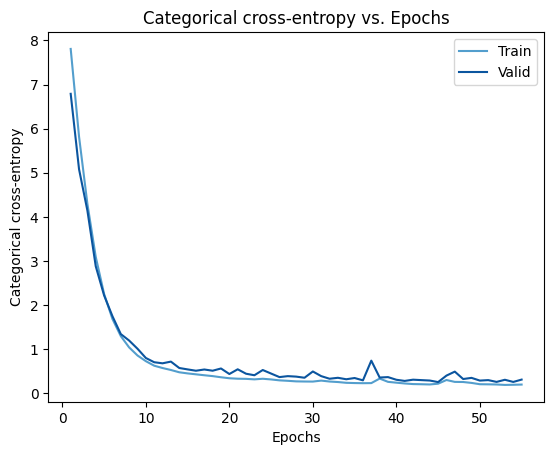

In [270]:
# Grafico loss function
epoch_count = range(1, len(hist.history["loss"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["loss"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist.history["val_loss"], label="Valid", color=blues_palette[5])
plt.ylabel('Categorical cross-entropy'); plt.xlabel('Epochs'); plt.title('Categorical cross-entropy vs. Epochs'); plt.show()

In [271]:
# Evalúo el set de testeo
model.evaluate(X_test, y_test)

142/142 [==============================] - 2s 7ms/step - loss: 1.4037 - f1_score: 0.6483


[1.4037377834320068, 0.6483367681503296]

In [272]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convierto y_test al mismo formato que las labels de predicción
y_test_labels = np.argmax(y_test, axis=1)

# Uso el classification_report de scikit-learn
report = classification_report(y_test_labels, y_pred_labels)

print(report)

142/142 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.39      0.50      0.44       474
           1       0.55      0.41      0.47      1547
           2       0.74      0.83      0.78      2508

    accuracy                           0.65      4529
   macro avg       0.56      0.58      0.56      4529
weighted avg       0.64      0.65      0.64      4529



Se exploraron diversas arquitecturas con el objetivo de mejorar el desempeño del modelo. Se realizaron cambios en el tipo y cantidad de capas, así como en la configuración de los hiperparámetros, como el número de nodos, el porcentaje de dropout, el optimizador y la tasa de aprendizaje. A pesar de estos esfuerzos, no se logró obtener un puntaje F1 en el conjunto de prueba superior al 65%.


###3 - Entrenamiento del modelo con Embeddings Fasttext + LSTM

A continuación se intenta utilizar embeddings pre-entrenados (FastText) con el fin de buscar una mejora a las métricas obtenidas en el apartado anterior. 

In [273]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0  53.0M      0  0:00:51  0:00:51 --:--:-- 69.6M


In [274]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [40]:
model_fasttext = FasttextEmbeddings()

In [ ]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('Preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(vocab_size, len(word2index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word2index o bien elegir otra librería para preprocesamiento

for word, i in word2index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('Number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

In [78]:
# Definimos el modelo
model2 = Sequential()

model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=128, return_sequences=True))
model2.add(Dropout(0.2))

model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences
model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))

model2.add(Dense(out_shape, activation="softmax"))
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[f1_score])

model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 116, 300)          2400000   
                                                                 
 lstm_16 (LSTM)              (None, 116, 128)          219648    
                                                                 
 dropout_20 (Dropout)        (None, 116, 128)          0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 3)                

In [79]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [80]:
hist2 = model2.fit(X_train_over, y_train_over, epochs=200, validation_split=0.2, callbacks=[callback], batch_size=2048)

Epoch 1/200
12/12 [==============================] - 7s 254ms/step - loss: 1.0794 - f1_score: 0.0066 - val_loss: 1.2695 - val_f1_score: 0.0000e+00
Epoch 2/200
12/12 [==============================] - 2s 197ms/step - loss: 1.0609 - f1_score: 0.2077 - val_loss: 1.3050 - val_f1_score: 0.0000e+00
Epoch 3/200
12/12 [==============================] - 2s 199ms/step - loss: 1.0463 - f1_score: 0.2042 - val_loss: 1.2227 - val_f1_score: 0.0060
Epoch 4/200
12/12 [==============================] - 2s 199ms/step - loss: 1.0275 - f1_score: 0.3212 - val_loss: 1.3557 - val_f1_score: 7.1709e-04
Epoch 5/200
12/12 [==============================] - 2s 188ms/step - loss: 1.0171 - f1_score: 0.3203 - val_loss: 1.1655 - val_f1_score: 0.1824
Epoch 6/200
12/12 [==============================] - 2s 202ms/step - loss: 1.0056 - f1_score: 0.3527 - val_loss: 1.3745 - val_f1_score: 0.0580
Epoch 7/200
12/12 [==============================] - 2s 201ms/step - loss: 0.9960 - f1_score: 0.3958 - val_loss: 1.1288 - val_f1_s

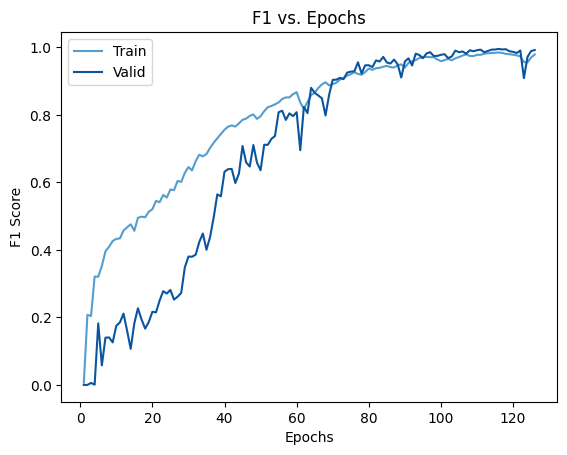

In [81]:
# Grafico F1 Score
blues_palette = sns.color_palette("Blues")
epoch_count = range(1, len(hist2.history["f1_score"]) + 1)
sns.lineplot(x=epoch_count, y=hist2.history["f1_score"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist2.history["val_f1_score"], label="Valid", color=blues_palette[5])
plt.ylabel('F1 Score'); plt.xlabel('Epochs'); plt.title('F1 vs. Epochs'); plt.show()

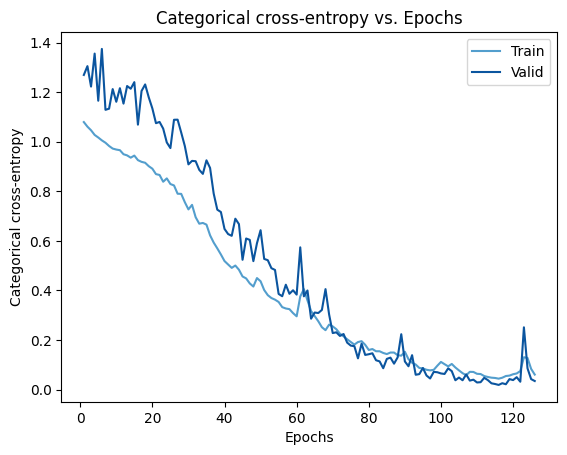

In [83]:
# Grafico loss function
epoch_count = range(1, len(hist2.history["loss"]) + 1)
sns.lineplot(x=epoch_count, y=hist2.history["loss"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist2.history["val_loss"], label="Valid", color=blues_palette[5])
plt.ylabel('Categorical cross-entropy'); plt.xlabel('Epochs'); plt.title('Categorical cross-entropy vs. Epochs'); plt.show()

In [84]:
# Evalúo el set de testeo
model2.evaluate(X_test, y_test)

142/142 [==============================] - 2s 7ms/step - loss: 3.1126 - f1_score: 0.5346


[3.1125786304473877, 0.534559428691864]

In [85]:
y_pred_prob = model2.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convierto y_test al mismo formato que las labels de predicción
y_test_labels = np.argmax(y_test, axis=1)

# Uso el classification_report de scikit-learn
report = classification_report(y_test_labels, y_pred_labels)

print(report)

142/142 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.25      0.24      0.25       474
           1       0.41      0.37      0.39      1547
           2       0.65      0.69      0.67      2508

    accuracy                           0.53      4529
   macro avg       0.44      0.43      0.44      4529
weighted avg       0.53      0.53      0.53      4529



In [120]:
# Creo mi diccionario de indices a palabras (opuesto a word2index)
index2word = {index: word for word, index in word2index.items()}
index2word[0] = '' # Agrego el indice 0 como vacio

# Selecciono 5 reviews random 
for i in range(5):
    idx = np.random.randint(len(y_test))
    review_tokens = [index2word[word] for word in X_test[idx]]
    review = " ".join(review_tokens).lstrip()

    # Predicciones de ambos modelos
    pred1 = model.predict(X_test[idx].reshape(1, -1))
    pred2 = model2.predict(X_test[idx].reshape(1, -1))

    print(f"Review {i+1}: {review}")
    print(f"Predicción modelo 1: {np.argmax(pred1)}")
    print(f"Predicción modelo 2: {np.argmax(pred2)}")
    print(f"Valor verdadero: {np.argmax(y_test[idx])}")
    print('-'*85)

1/1 [==============================] - 0s 23ms/step
Review 1: great basic skirt to have it flows beautifully and the print is a classic with a twist it can be dressed up or down with heels or flats a great addition to my wardrobe
Predicción modelo 1: 2
Predicción modelo 2: 2
Valor verdadero: 2
-------------------------------------------------------------------------------------
1/1 [==============================] - 0s 23ms/step
Review 2: this is a beautiful casual top it is a loose fit that is generously sized so instead of my usual large i purchased the medium for a better fit the length is perfect not too long or short the colors coordinate great with denim
Predicción modelo 1: 2
Predicción modelo 2: 2
Valor verdadero: 2
-------------------------------------------------------------------------------------
1/1 [==============================] - 0s 23ms/step
Review 3: 1 i'm 5'5 tall 145 lbs and 38 32 40 and the pilcro hyphen chinos and stet chinos fit me perfectly if a bit loose in th

### 4 - Conclusiones

Se concluye que, si bien los resultados del entrenamiento de ambos modelos son satisfactorios, al evaluarlos en el conjunto de prueba se obtienen métricas bastante bajas. Esto puede deberse al desbalance en las clases presentes en el conjunto de prueba, lo que hace que los modelos tiendan a predecir con mayor frecuencia la clase 2, que corresponde a los ratings de 5 estrellas.

A pesar de haber probado diversas configuraciones en ambos modelos e incluso mantener las 5 clases originales, no se logró obtener una red neuronal que obtenga mejores resultados. Sin embargo, al realizar múltiples predicciones en el conjunto de prueba, se observa que las predicciones no son tan desfavorables en general. Es importante destacar que no se encontraron casos en los que se predijera el rating opuesto, como clasificar la clase 0 (Malo) cuando en realidad era 2 (Muy Bueno), o viceversa. Por lo tanto, se concluye que este modelo al menos tiene la capacidad de distinguir entre sentimientos positivos y negativos. Una alternativa para mejorar el desempeño puede ser transformar este problema en una clasificación binaria, donde se determine si el cliente está satisfecho o no con el producto.